In [31]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics   #Additional     scklearn functions
from sklearn.model_selection import GridSearchCV   #Perforing grid search
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.model_selection import cross_val_score
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4
 
train = pd.read_csv('df_training.csv')
#train.dropna()
target = 'TARGET'
IDcol = 'ID'
#train=pd.get_dummies(train)

predictors = [x for x in train.columns if x not in [target,IDcol]]

import warnings
warnings.filterwarnings('ignore')

In [32]:
train.TARGET.value_counts()

0    4777
1    1223
Name: TARGET, dtype: int64

In [33]:
train.head()

,ID,Product_using_score,User_area,gender,age,Cumulative_using_time,Point_balance,Product_service_usage,Pay_a_monthly_fee_by_credit_card,Active_user,Estimated_salary,TARGET
0,6518,628.0,NaN,Female,51.0,NaN,155903.82,2.0,1.0,1.0,71159.84,0
1,5195,696.0,Taipei,NaN,27.0,4.0,NaN,2.0,0.0,NaN,196111.35,0
2,1786,NaN,Taichung,Male,40.0,3.0,NaN,2.0,1.0,1.0,NaN,0
3,6151,NaN,NaN,Male,NaN,NaN,NaN,NaN,1.0,0.0,NaN,1
4,7577,NaN,Tainan,NaN,27.0,NaN,0.00,1.0,NaN,1.0,107955.67,0


In [25]:
train.head()

,ID,Product_using_score,age,Cumulative_using_time,Point_balance,Product_service_usage,Pay_a_monthly_fee_by_credit_card,Active_user,Estimated_salary,TARGET,User_area_Taichung,User_area_Tainan,User_area_Taipei,gender_Female,gender_Male
0,6518,628.0,51.0,NaN,155903.82,2.0,1.0,1.0,71159.84,0,0,0,0,1,0
1,5195,696.0,27.0,4.0,NaN,2.0,0.0,NaN,196111.35,0,0,0,1,0,0
2,1786,NaN,40.0,3.0,NaN,2.0,1.0,1.0,NaN,0,1,0,0,0,1
3,6151,NaN,NaN,NaN,NaN,NaN,1.0,0.0,NaN,1,0,0,0,0,1
4,7577,NaN,27.0,NaN,0.00,1.0,NaN,1.0,107955.67,0,0,1,0,0,0


In [34]:
train.Cumulative_using_time.describe()

count    4207.000000
mean        5.006418
std         2.882664
min         0.000000
25%         3.000000
50%         5.000000
75%         8.000000
max        10.000000
Name: Cumulative_using_time, dtype: float64

In [35]:

def f1_score_vail(pred, data_vail):
    labels = data_vail.get_label() 
    preds = []
    for i in pred: 
        if i > 0.5:
            preds.append(1)
        else:
            preds.append(0) 
    score_vail = f1_score(y_true=labels, y_pred=preds, average='binary')      # xgb的predict输出即为对应的label
    return '1-f1_score', 1-score_vail   # xgb目标是将目标指标降低


In [5]:
def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])

    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['TARGET'],eval_metric='auc')

    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]

    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(dtrain['TARGET'].values, dtrain_predictions))
    print ("f1 : %.4g" % metrics.f1_score(dtrain['TARGET'].values, dtrain_predictions))
    print ("precesion : %.4g" % metrics.precision_score(dtrain['TARGET'].values, dtrain_predictions))
    print ("recall : %.4g" % metrics.recall_score(dtrain['TARGET'].values, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['TARGET'], dtrain_predprob))

    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')


In [15]:
param_test0 = {
 'n_estimators':range(40,42,1),
 'learning_rate':[0.09,0.1]
}

param_test1 = {
 'max_depth':range(9,12,1),
 'min_child_weight':range(6,7,1)
}
param_test2 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
param_test3 = {
 'subsample':[i/100 for i in range(90,100,5)],
 'colsample_bytree':[i/100 for i in range(65,80,5)]
}
param_test4 = {
 'reg_alpha':[1.1]
}
param_test5 = {
 'scale_pos_weight':[2.5]
}
gsearch0 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=40, max_depth=9,
 min_child_weight=6, gamma=0, subsample=0.9, colsample_bytree=0.7,reg_alpha=1.1,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=2.5,seed=27), 
 param_grid = param_test5, scoring='f1',n_jobs=4,iid=False, cv=5)
gsearch0.fit(train[predictors],train[target])
gsearch0.best_params_,    gsearch0.best_score_


({'scale_pos_weight': 2.5}, 0.5272528303372349)

In [120]:
from sklearn.ensemble import BaggingClassifier
bagging_clf = BaggingClassifier(gsearch0,n_estimators=20)
# 计算交叉验证的准确率
#scores = cross_val_score(bagging_clf, train_data, train_target, cv=3)
#print(scores.mean())
estimate(bagging_clf)

precision 0.5219956509142601
recall 0.5175663631545985
f1 0.5133730584277115


In [1]:
a = 0.5219956509142601
b = 0.5175663631545985
2*a*b/(a+b)

0.5197715710461033

In [108]:
bagging_clf.fit(train[predictors],train[target])

BaggingClassifier(base_estimator=GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.7, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=9,
       min_child_weight=6, missi...1]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='f1', verbose=0),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=20, n_jobs=None, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [109]:
test_data = pd.read_csv('df_test.csv')
test_data_id = test_data.ID
test_data.drop('ID',axis=1,inplace=True)
test_data.drop('TARGET',axis=1,inplace=True)
test_data = pd.get_dummies(test_data)
test_data.head()

,Product_using_score,age,Cumulative_using_time,Point_balance,Product_service_usage,Pay_a_monthly_fee_by_credit_card,Active_user,Estimated_salary,User_area_Taichung,User_area_Tainan,User_area_Taipei,gender_Female,gender_Male
0,655.0,37.0,4.0,108862.76,NaN,1.0,0.0,79555.08,1,0,0,1,0
1,NaN,52.0,9.0,111973.97,1.0,NaN,1.0,NaN,1,0,0,0,0
2,519.0,21.0,1.0,146329.57,2.0,1.0,1.0,194867.27,0,0,1,0,0
3,NaN,NaN,NaN,0.00,2.0,0.0,0.0,96398.51,0,1,0,0,1
4,NaN,33.0,10.0,138847.90,NaN,1.0,NaN,127256.70,0,0,0,1,0


In [110]:
rs = bagging_clf.predict(test_data)


In [113]:
train.TARGET.values.sum()/6000

0.20383333333333334

In [114]:
rs.sum()/2000

0.205

In [115]:
df = pd.DataFrame()

In [116]:
df['ID'] = test_data_id

In [117]:
df['Predicted_Results'] = np.array(rs)

In [118]:
df.to_csv('result.csv',index=False)


Model Report
Accuracy : 0.9878
f1 : 0.9646
precesion : 0.9317
recall : 1
AUC Score (Train): 0.999938


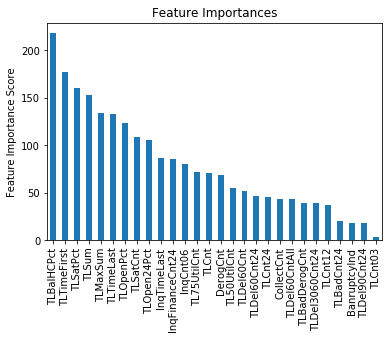

In [5]:
xgb1 = XGBClassifier(
 learning_rate =0.11,
 n_estimators=39,
 max_depth=7,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=5,
 seed=27)
modelfit(xgb1, train, predictors)

In [119]:
def estimate(estimator, name='estimator'):
    #estimator.fit(train[predictors], train[target])
    #auc = cross_val_score(estimator,train[predictors],train[target], scoring='roc_auc', cv=3).mean()
    precision = cross_val_score(estimator, train[predictors],train[target], scoring='precision', cv=3).mean()
    f1 = cross_val_score(estimator, train[predictors],train[target], scoring='f1', cv=3).mean()
    recall = cross_val_score(estimator, train[predictors],train[target], scoring='recall', cv=3).mean()

    #print('auc',auc)
    print('precision',precision)    
    print('recall',recall)    
    print('f1',f1)        